##  Инструкция по выполнению проекта

### Описание процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.


### Цель проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

## Предварительный анализ данных

### Подготовка данных

#### Загрузка приложений

In [1]:
import os

import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython import get_ipython
ipython = get_ipython()


# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

#ml
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
%pip install catboost
from catboost import CatBoostRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns 

import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


import warnings 
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

Note: you may need to restart the kernel to use updated packages.


In [2]:
#немного опций для удобства

pd.options.display.max_rows = 7
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

large = 16; med = 12; small = 10
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (12, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

sns.set_palette('deep') 
sns.set_style("whitegrid")

from matplotlib import rcParams, rcParamsDefault

rcParams['figure.figsize'] = 8,2
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
factor = 10
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi*factor

#### Загрузка  файлов

In [3]:
# загружаем файлы

pth1='/home/alexandra/data_science/final_steel/data_arc.csv'
pth2='/datasets/final_steel/data_arc.csv'
pth3='/content/data_arc.csv'

try:
  
    if os.path.exists(pth1):
        data_arc = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_arc = pd.read_csv(pth2, delimiter='\,')
    else:
        data_arc = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_arc.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

pth1='/home/alexandra/data_science/final_steel/data_bulk.csv'
pth2='/datasets/final_steel/data_bulk.csv'
pth3='/content/data_bulk.csv'

try:
  
    if os.path.exists(pth1):
        data_bulk = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_bulk = pd.read_csv(pth2, delimiter='\,')
    else:
        data_bulk = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_bulk.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

pth1='/home/alexandra/data_science/final_steel/data_bulk_time.csv'
pth2='/datasets/final_steel/data_bulk_time.csv'
pth3='/content/data_bulk_time.csv'

try:
  
    if os.path.exists(pth1):
        data_bulk_time = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_bulk_time = pd.read_csv(pth2, delimiter='\,')
    else:
        data_bulk_time = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_bulk_time.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

pth1='/home/alexandra/data_science/final_steel/data_gas.csv'
pth2='/datasets/final_steel/data_gas.csv'
pth3='/content/data_gas.csv'

try:
  
    if os.path.exists(pth1):
        data_gas = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_gas = pd.read_csv(pth2, delimiter='\,')
    else:
        data_gas = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_gas.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

pth1='/home/alexandra/data_science/final_steel/data_temp.csv'
pth2='/datasets/final_steel/data_temp.csv'
pth3='/content/data_temp.csv'

try:
  
    if os.path.exists(pth1):
        data_temp = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_temp = pd.read_csv(pth2, delimiter='\,')
    else:
        data_temp = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_temp.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')

pth1='/home/alexandra/data_science/final_steel/data_wire.csv'
pth2='/datasets/final_steel/data_wire.csv'
pth3='/content/data_wire.csv'

try:
  
    if os.path.exists(pth1):
        data_wire = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_wire = pd.read_csv(pth2, delimiter='\,')
    else:
        data_wire = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_wire.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')


pth1='/home/alexandra/data_science/final_steel/data_wire_time.csv'
pth2='/datasets/final_steel/data_wire_time.csv'
pth3='/content/data_wire_time.csv'

try:
  
    if os.path.exists(pth1):
        data_wire_time = pd.read_csv(pth1, delimiter='\,')
    elif os.path.exists(pth2):
        data_wire_time = pd.read_csv(pth2, delimiter='\,')
    else:
        data_wire_time = pd.read_csv(pth3, delimiter='\,')
  
    print('Загрузка файла data_wire_time.csv прошла успешно')      
except:
    print('Ошибка загрузки файла. Проверьте путь к файлу.')



Загрузка файла data_arc.csv прошла успешно
Загрузка файла data_bulk.csv прошла успешно
Загрузка файла data_bulk_time.csv прошла успешно
Загрузка файла data_gas.csv прошла успешно
Загрузка файла data_temp.csv прошла успешно
Загрузка файла data_wire.csv прошла успешно
Загрузка файла data_wire_time.csv прошла успешно


#### Первичная информация

In [4]:
df=[data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [5]:
for data in df:
    display(data)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
...,...,...,...,...,...
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768
14875,3241,2019-09-01 04:34:47,2019-09-01 04:36:08,0.306580,0.196708


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 04:05:34,2019-09-01 04:05:34


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
...,...,...
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
...,...,...,...
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN
15906,3241,2019-09-01 04:38:08,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-01 04:16:01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
for data in df:
    data.info()
    print( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-

### Анализ данных

#### Проверка на коллинеарность

In [7]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

data_arc['время раб электрода']=(data_arc['Конец нагрева дугой']-data_arc['Начало нагрева дугой'])/ np.timedelta64 ( 1 , 's')

data_arc['Полная мощ']= data_arc['Активная мощность']+data_arc['Реактивная мощность']

data_arc_aggr=pd.pivot_table(data_arc, index='key', values=['время раб электрода', 'Полная мощ'],aggfunc=['sum'])
data_arc_aggr.columns = ["_".join((i,j)) for i,j in data_arc_aggr.columns]
data_arc_aggr = data_arc_aggr.reset_index()
data_arc_aggr

#data_arc = data_arc.merge(data_temp, how='right', on='key')


,key,sum_Полная мощ,sum_время раб электрода
0,1,8.061388,1098.0
1,2,5.050710,811.0
2,3,4.124958,655.0
...,...,...,...
3211,3239,7.778372,1216.0
3212,3240,5.467350,839.0
3213,3241,4.167646,659.0


In [9]:
data_temp['Время замера']=pd.to_datetime(data_temp['Время замера'])
data_temp=data_temp.dropna()
data_temp.query("key == 1")


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [10]:
data_temp_aggr=data_temp.groupby('key').count().reset_index()

data_temp_aggr
data_temp_aggr=data_temp_aggr.query("Температура > 2")
data_temp_aggr

data_temp=data_temp[data_temp['key'].isin(data_temp_aggr['key'])]
data_temp

,key,Время замера,Температура
0,1,5,5
1,2,6,6
2,3,5,5
...,...,...,...
3213,3239,1,1
3214,3240,1,1
3215,3241,1,1


,key,Время замера,Температура
0,1,5,5
1,2,6,6
2,3,5,5
...,...,...,...
2473,2496,4,4
2475,2498,5,5
2476,2499,3,3


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
...,...,...,...
12264,2499,2019-08-06 02:40:25,1569.0
12265,2499,2019-08-06 02:54:24,1604.0
12266,2499,2019-08-06 03:00:28,1603.0


In [11]:
data_temp_agg_min = pd.pivot_table(data_temp, index='key', values=['Время замера'], aggfunc='min').reset_index()
data_temp_min = data_temp.merge(data_temp_agg_min, how='inner', on=['Время замера', 'key'])

data_temp_agg_max = pd.pivot_table(data_temp, index='key', values=['Время замера'], aggfunc='max').reset_index()
data_temp_max = data_temp.merge(data_temp_agg_max, how='inner', on=['Время замера', 'key'])

data_temp_min
data_temp_max

data_temp = data_temp_min.merge(data_temp_max, how='inner', on='key')
data_temp=data_temp.drop(['Время замера_x', 'Время замера_y'], axis=1)
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:13:17,1596.0
...,...,...,...
2416,2496,2019-08-06 01:02:54,1554.0
2417,2498,2019-08-06 02:03:49,1591.0
2418,2499,2019-08-06 02:40:25,1569.0


,key,Время замера,Температура
0,1,2019-05-03 11:30:39,1613.0
1,2,2019-05-03 11:59:12,1602.0
2,3,2019-05-03 12:34:57,1599.0
...,...,...,...
2416,2496,2019-08-06 01:29:52,1591.0
2417,2498,2019-08-06 02:25:31,1594.0
2418,2499,2019-08-06 03:00:28,1603.0


,key,Температура_x,Температура_y
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
...,...,...,...
2416,2496,1554.0,1591.0
2417,2498,1591.0,1594.0
2418,2499,1569.0,1603.0


In [12]:
df = data_arc_aggr.merge(data_temp, how='inner', on='key')
df = df.merge(data_gas, how='inner', on='key')
df
df=df.loc[df['sum_Полная мощ']>0]


,key,sum_Полная мощ,sum_время раб электрода,Температура_x,Температура_y,Газ 1
0,1,8.061388,1098.0,1571.0,1613.0,29.749986
1,2,5.050710,811.0,1581.0,1602.0,12.555561
2,3,4.124958,655.0,1596.0,1599.0,28.554793
...,...,...,...,...,...,...
2414,2496,7.013249,940.0,1554.0,1591.0,9.412616
2415,2498,5.764154,750.0,1591.0,1594.0,14.953657
2416,2499,6.876296,883.0,1569.0,1603.0,11.336151


#### Графическое представление данных

In [8]:
!pip install phik

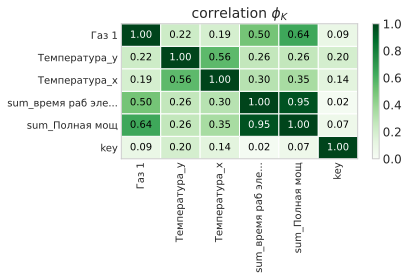

In [13]:
# проверяем данные на коллинеарность
from phik.report import correlation_report, plot_correlation_matrix

interval_cols = df.select_dtypes('number').columns.tolist()
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(6, 4))
plt.tight_layout()

Целевая метрика - последняя температура ковша.

Выводы:

Нет температуры в наскольких партиях. Я бы удалила эти данные про эти партии.

Наблюдается сильная корреляция между полной мощностью и временем работы электрода. Работы здесь нет смысла вычмслять,т.к. эти вещи взаимосвязаны. Я оставлю всемя работы электрода, т.к. оно больше связано с конечной тепрературой.

По ящикам с усами наблюдается отрицательное значение мощности - его убрала. Далее особых выбросов я не вижу. Это вполне согласуется с экспериментами и техническим процессом. Единственное - я бы убрала данные по температуре ниже 1400. Остальное бы оставила.

### План работ

**1. Проведение обзора данных**

**Подготовка данных:** 
* Загрузка библиотек;
* Загрузка файлов;
* Просмотр таблиц и информиции о их;

**Анализ данных:**
* Графическое представление данных из таблиц;
* Проверка данных на коллинеарность.

**Предобработка данных:**
* Заполнение пропусков / удаление дубликатов;
* Соединение таблиц;
* Выделение признаков и таргета.

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* графический анализ


**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели случайного леса;
* Обучение модели градиентного бустинга с перебором гиперпараметров;
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

### Предобработка данных

#### Заполнение пропусков / удаление дубликатов

In [14]:
df=df.dropna(axis=0)

In [15]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)


#### Соединение таблиц

In [16]:
#data_wire['w_sum']=data_wire['Wire 2']+data_wire['Wire 3']+data_wire['Wire 4']+data_wire['Wire 5']+data_wire['Wire 6']+data_wire['Wire 7']+data_wire['Wire 8']+data_wire['Wire 9']
#data_bulk['b_sum']=data_bulk['Bulk 1']+data_bulk['Bulk 2']+data_bulk['Bulk 3']+data_bulk['Bulk 4']+data_bulk['Bulk 5']+data_bulk['Bulk 6']+data_bulk['Bulk 7']+data_bulk['Bulk 8']+data_bulk['Bulk 9']+data_bulk['Bulk 10']+data_bulk['Bulk 11']+data_bulk['Bulk 13']

data_wire_new=data_wire.drop(['Wire 5','Wire 6','Wire 7','Wire 8','Wire 9'], axis=1) 
data_bulk_new=data_bulk.drop(['Bulk 2','Bulk 5','Bulk 6','Bulk 7','Bulk 8','Bulk 9','Bulk 10','Bulk 11','Bulk 13'], axis=1)


<div class="alert alert-info"> <b>Комментарий студента: "Изначально были обьединены все столбцы в одну таблицу и сделан предварительный расчет. Анализ влияющих факторов показал, что некоторые столбцы можно удалить, т.к. влияние их практически нулевое"</b> 

In [17]:
df = df.merge(data_wire_new, how='inner', on='key')
df = df.merge(data_bulk_new, how='inner', on='key')


In [18]:
df=df.drop(['key','sum_время раб электрода'], axis=1)
df=df.loc[df['Температура_x']>1400]
df
df.info()

,sum_Полная мощ,Температура_x,Температура_y,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Bulk 1,Bulk 3,Bulk 4,Bulk 12,Bulk 14,Bulk 15
0,8.061388,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,43.0,206.0,150.0,154.0
1,5.050710,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,73.0,206.0,149.0,154.0
2,4.124958,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,34.0,205.0,152.0,153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278,7.013249,1554.0,1591.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,63.0,256.0,129.0,226.0
2279,5.764154,1591.0,1594.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,90.0,0.0,206.0,129.0,207.0
2280,6.876296,1569.0,1603.0,11.336151,110.160958,50.00528,0.0,0.0,0.0,47.0,0.0,233.0,126.0,227.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277 entries, 0 to 2280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sum_Полная мощ  2277 non-null   float64
 1   Температура_x   2277 non-null   float64
 2   Температура_y   2277 non-null   float64
 3   Газ 1           2277 non-null   float64
 4   Wire 1          2277 non-null   float64
 5   Wire 2          2277 non-null   float64
 6   Wire 3          2277 non-null   float64
 7   Wire 4          2277 non-null   float64
 8   Bulk 1          2277 non-null   float64
 9   Bulk 3          2277 non-null   float64
 10  Bulk 4          2277 non-null   float64
 11  Bulk 12         2277 non-null   float64
 12  Bulk 14         2277 non-null   float64
 13  Bulk 15         2277 non-null   float64
dtypes: float64(14)
memory usage: 266.8 KB


#### Выделение признаков и таргета

In [19]:
# Делим наши данные 
target = df['Температура_y']
features = df.drop('Температура_y', axis=1)


In [20]:
#Разделение данных на обучающую и тестовую выборки
features_test, features_train, target_test, target_train = train_test_split(features, target, test_size=0.75, random_state=270323)

features_train.shape
features_test.shape

(1708, 13)

(569, 13)

### Исследование итоговой таблицы с данными

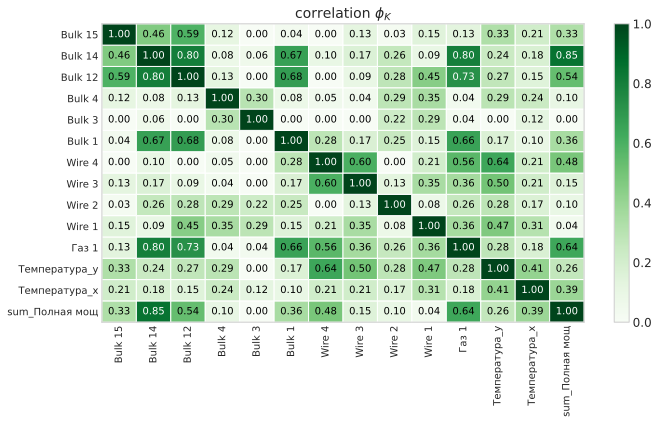

In [21]:
from phik.report import correlation_report, plot_correlation_matrix

interval_cols = df.select_dtypes('number').columns.tolist()
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(10, 6))
plt.tight_layout()

<AxesSubplot:xlabel='sum_Полная мощ', ylabel='Count'>

<AxesSubplot:xlabel='Газ 1', ylabel='Count'>

<AxesSubplot:xlabel='Bulk 12', ylabel='Count'>

<AxesSubplot:xlabel='Wire 3', ylabel='Count'>

<AxesSubplot:xlabel='Wire 1', ylabel='Count'>

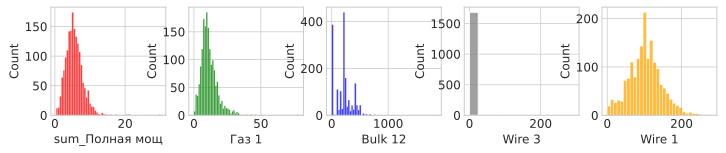

In [22]:
#проверяем

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12,2))
sns.histplot(x=features_train['sum_Полная мощ'], color='r', ax=axes[0])
sns.histplot(x=features_train['Газ 1'], color='green', ax=axes[1])
sns.histplot(x=features_train['Bulk 12'], color='b', ax=axes[2])
sns.histplot(x=features_train['Wire 3'], color='gray', ax=axes[3])
sns.histplot(x=features_train['Wire 1'], color='orange', ax=axes[4])

<AxesSubplot:xlabel='Температура_y', ylabel='Count'>

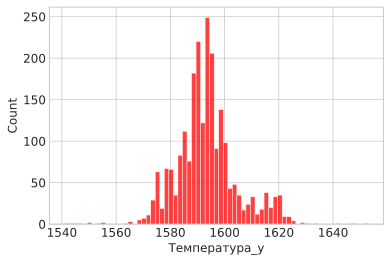

In [23]:
sns.histplot(x=target, color='r')

## Построение модели машинного обучения

### Обучение модели

#### Масштабирование данных

In [24]:
#numeric = ['sum_Полная мощ', 'Газ 1', 'Wire 1', 'Bulk 12', 'Bulk 15', 'b_sum', 'Bulk 14', 'w_sum']

numeric=features_train.columns.values.tolist()

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric]= scaler.transform(features_test[numeric])


StandardScaler()

#### Построение пайплайна

In [25]:
pipe_cbc = Pipeline([('clf',CatBoostRegressor())])

pipe_rfr = Pipeline([('clf', RandomForestRegressor(random_state=270323))])

pipe_lgbm = Pipeline([('clf', LGBMRegressor(boosting_type='gbdt'))])


In [26]:
grid_params_cbc = [{'clf__depth': range(1,10,1), 'clf__iterations': range(1,100,5)}]

grid_params_rfr = [{'clf__max_depth': range(9,13,1), 'clf__n_estimators': range(400, 500, 10)}]

grid_params_lgbm = [{'clf__max_depth': range(3,10,1),
                     'clf__n_estimators': range(100, 200, 10),
                     'clf__num_leaves': range(4,11,2)}]

CBC = GridSearchCV(estimator=pipe_cbc,
                   param_grid=grid_params_cbc,
                   scoring='neg_mean_absolute_error',
                   cv=5, 
                   n_jobs=-1)

RFR = GridSearchCV(estimator=pipe_rfr,
                   param_grid=grid_params_rfr,
                   scoring='neg_mean_absolute_error',
                   cv=5, 
                   n_jobs=-1)

LGBM = GridSearchCV(estimator=pipe_lgbm,
                    param_grid=grid_params_lgbm,
                    scoring='neg_mean_absolute_error',
                    cv=5, 
                    n_jobs=-1)

grids = [RFR, CBC, LGBM]

grid_dict = {0: 'RandomForestR',
             1: 'CatBoostR',
             2: 'LGBMRegressor'}

#### Выбор лучшей модели

In [27]:
print('Performing model optimizations...')
best_acc = -100.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    gs.fit(features_train, target_train)
    print('Best params are : %s' % gs.best_params_)
    print('Best training accuracy: %.3f' % gs.best_score_)
    if  gs.best_score_ > best_acc:
        best_acc = gs.best_score_
        best_gs = gs
        best_clf = idx
        best_param = gs.best_params_
        
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_clf])

Performing model optimizations...

Estimator: RandomForestR


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        RandomForestRegressor(random_state=270323))]),
             n_jobs=-1,
             param_grid=[{'clf__max_depth': range(9, 13),
                          'clf__n_estimators': range(450, 500, 10)}],
             scoring='neg_mean_absolute_error')

Best params are : {'clf__max_depth': 12, 'clf__n_estimators': 460}
Best training accuracy: -6.206

Estimator: CatBoostR
Learning rate set to 0.373694
0:	learn: 10.1747682	total: 210ms	remaining: 14.5s
1:	learn: 9.4764446	total: 297ms	remaining: 10.1s
2:	learn: 9.0190952	total: 396ms	remaining: 8.85s
3:	learn: 8.6069648	total: 494ms	remaining: 8.15s
4:	learn: 8.2818320	total: 591ms	remaining: 7.69s
5:	learn: 8.0237378	total: 684ms	remaining: 7.29s
6:	learn: 7.7968411	total: 694ms	remaining: 6.25s
7:	learn: 7.5878789	total: 706ms	remaining: 5.47s
8:	learn: 7.4840182	total: 717ms	remaining: 4.86s
9:	learn: 7.3238585	total: 811ms	remaining: 4.87s
10:	learn: 7.1894582	total: 821ms	remaining: 4.4s
11:	learn: 7.1120001	total: 906ms	remaining: 4.38s
12:	learn: 7.0395839	total: 914ms	remaining: 4.01s
13:	learn: 6.9262114	total: 1.01s	remaining: 4.05s
14:	learn: 6.8886208	total: 1.11s	remaining: 4.07s
15:	learn: 6.7797688	total: 1.12s	remaining: 3.78s
16:	learn: 6.6831364	total: 1.21s	remaining:

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        <catboost.core.CatBoostRegressor object at 0x7fec9786a790>)]),
             n_jobs=-1,
             param_grid=[{'clf__depth': range(8, 10),
                          'clf__iterations': range(70, 100, 5)}],
             scoring='neg_mean_absolute_error')

Best params are : {'clf__depth': 9, 'clf__iterations': 95}
Best training accuracy: -6.348

Estimator: LGBMRegressor


KeyboardInterrupt: 

In [28]:
data = pd.DataFrame({'Мethod': ['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor'], 
                     'МАЕ': [6.2, 6.1, 6.1]})

In [29]:
data

,Мethod,МАЕ
0,RandomForestRegressor,6.2
1,CatBoostRegressor,6.1
2,LGBMRegressor,6.1


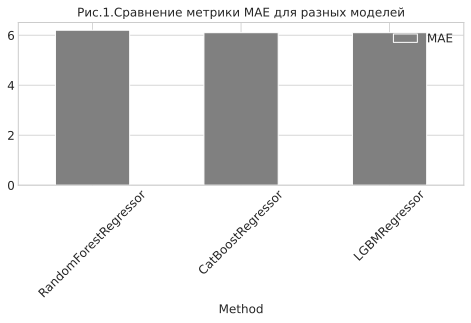

In [30]:
#для наглядности сделаем графики
data.plot.bar(x='Мethod', y='МАЕ', rot=45, color='grey', figsize=(8, 3))
plt.title("Рис.1.Сравнение метрики МАЕ для разных моделей")
plt.show;

### Проверка моделей

#### Тестирование лучшей модели на тестовой выборке

В данной работе наилучший результат показала модель

In [31]:
model = CatBoostRegressor(depth=4, iterations=75)
model.fit(features_train, target_train)
preds = model.predict(features_test).round()
mae=mean_absolute_error(target_test, preds)


Learning rate set to 0.366006
0:	learn: 10.5621198	total: 1.39ms	remaining: 103ms
1:	learn: 9.9169869	total: 4.27ms	remaining: 156ms
2:	learn: 9.4300231	total: 6.46ms	remaining: 155ms
3:	learn: 9.1354502	total: 9.29ms	remaining: 165ms
4:	learn: 8.9368958	total: 14ms	remaining: 196ms
5:	learn: 8.7859212	total: 15.6ms	remaining: 179ms
6:	learn: 8.6604950	total: 17.1ms	remaining: 166ms
7:	learn: 8.4959270	total: 18.7ms	remaining: 157ms
8:	learn: 8.4517743	total: 20.3ms	remaining: 149ms
9:	learn: 8.3472500	total: 22.9ms	remaining: 149ms
10:	learn: 8.2534609	total: 24.7ms	remaining: 144ms
11:	learn: 8.1941320	total: 26.4ms	remaining: 139ms
12:	learn: 8.1463231	total: 28.1ms	remaining: 134ms
13:	learn: 8.0642296	total: 29.7ms	remaining: 130ms
14:	learn: 8.0120276	total: 31.5ms	remaining: 126ms
15:	learn: 7.9338137	total: 33.4ms	remaining: 123ms
16:	learn: 7.8920797	total: 34.9ms	remaining: 119ms
17:	learn: 7.8370120	total: 36.6ms	remaining: 116ms
18:	learn: 7.8050551	total: 125ms	remaining: 

In [32]:
print("MAE тестовой выборки:", mae)

MAE тестовой выборки: 6.51493848857645


#### Анализ важности факторов

In [33]:
importances = model.feature_importances_  # train_features is the dataframe of training features
feature_list = list(features_test.columns)  # Extract the feature importances into a dataframe 
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})  # Show the top 10 most important 
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)  
feature_results.head(10) 

,feature,importance
0,sum_Полная мощ,29.197069
1,Температура_x,28.092603
2,Wire 1,7.090992
...,...,...
7,Bulk 1,3.953027
8,Bulk 4,3.459756
9,Bulk 14,3.355805


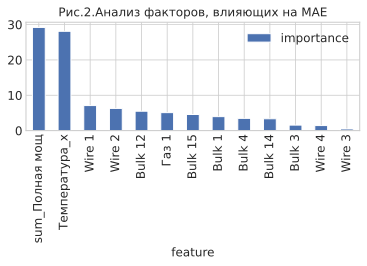

In [34]:
feature_results.plot(x='feature', y='importance', kind='bar', figsize=(6, 2))
plt.title("Рис.2.Анализ факторов, влияющих на МАЕ")
plt.show;

## Отчет

1. В данном проекте была исследована температура ковша при плавлении стали вразных технологических условиях. Для этого были использованы данные по продувке газом, по примесям, добавленным в разные моменты плавки, по нагреву электродами.

Все пункты плана были выполнены. 
Возникли трудности с предобработкой таблицы с температорой, но они были решены. 
Ключевыми шагами являлись: предварительный анализ данных и определение целевой метрики, предобработка данных, поиск наилучшей модели и тестирование результата.
Итоговой моделью стала CatBoostRegration, Тестовая метрика MAE составила 6.5.


2. Для исследования была  сформирована таблица, в которую вошли данные по сыпучим примесям, причем некоторые примеси были объеденены. Также вошли данные по продувке газом, по суммарной мощности нагрева электродами и по добавкам проволоки, причем также некоторые данные были объеденены в виду их незначительности. Целевым признаком была выбрана мемпература ковша по последнему измерению. Начальная температурв ковша была добавлена в признаки. При анализе данных были удалены данные по экспериментам, по которым было проведено два и менее замера температуры, а также те, в которых температура была ниже 1400. Все остальные данные мы постарались сохранить и учесть. Изначально были обьединены все признаки в одну таблицу и сделан предварительный расчет. Анализ влияющих факторов показал, что некоторые признаки по сыпучим и проволочным добавкам можно удалить, т.к. влияние их практически нулевое.


3. Для исследования были протестированы модели Случайного леса, CatBoost и LGBM. Наилучший результат с учетом временных затрат показала модель CatBoostRegressor(depth=4, iterations=75). На рисунке 1 приведена диаграмма, показывающая лучшие метрики для моделей, полученные на обучающей выборке.
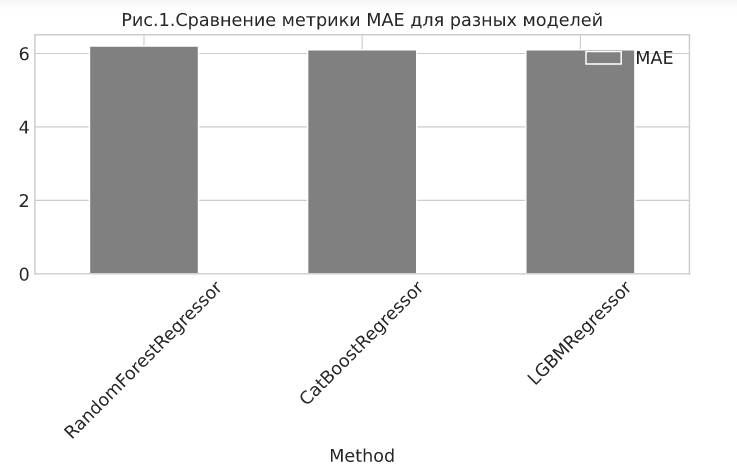


4. Анализ факторов, влияющих на результат расчетов, показан на рисунке 2. Наибольшее влияние оказали полная мощнось нагрева электродами, а также начальная температура ковша. Но действительно, реально необходимо брать за целевую метрику разность темератур ковша, так как понятно, что чем выше изначально нагрели ковш - тем меньше теплопотери при плавке стали. Кроме того, надо более точно учитывать активную и реактивную мощности, смотреть на что уходит реативная мощность и это уже вопрос к технологам. Далее, мне кажется необходима информация о конечных свойствах стали, возможно какие то свойства, которые меняются при использовании добавок. 
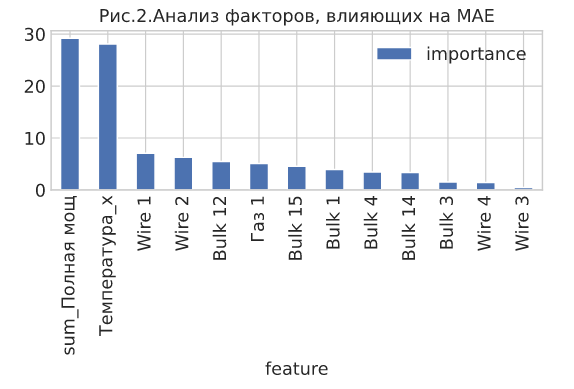
